In [128]:
import os
import sys
import yaml
import copy
import warnings
import importlib as imp
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pcl
import pyntcloud

sys.path.append('/home/jovyan/work/obstacle-detection/')

In [118]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [139]:
# Segments id -> name mapping
seg_lst = config['segments']
# seg_lst

In [125]:
# Obstacles id -> name mapping
obstacle_lst = config['obstacles']
obstacle_lst

{10: 'car',
 11: 'bicycle',
 13: 'bus',
 15: 'motorcycle',
 16: 'on-rails',
 18: 'truck',
 20: 'other-vehicle',
 30: 'person',
 31: 'bicyclist',
 32: 'motorcyclist',
 252: 'moving-car',
 253: 'moving-bicyclist',
 254: 'moving-person',
 255: 'moving-motorcyclist',
 256: 'moving-on-rails',
 257: 'moving-bus',
 258: 'moving-truck',
 259: 'moving-other-vehicle'}

In [136]:
num ='066'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [147]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
print('Scan have:')
for seg in unq:
    if seg in list(seg_lst.keys()):
        print(seg, seg_lst[seg])

Scan have:
0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
40 road
72 terrain
10 car
11 bicycle
44 parking
80 pole
81 traffic-sign
50 building
51 fence
48 sidewalk
20 other-vehicle
60 lane-marking
253 moving-bicyclist


In [165]:
# pcloud = pyntcloud.PyntCloud(pcloud)

In [261]:
# pcloud = pd.DataFrame(scan, columns=['x', 'y', 'z'])
# test_cloud.plot(use_as_color='seg_id', cmap="cool")

In [166]:
# pcloud.plot(use_as_color='camera', cmap="cool")

In [294]:
# is_parking = ~test_cloud.points['seg_id'].isin(list(obstacle_lst.keys()))
# test_cloud.points['is_parking'] = pd.Series(is_parking)

In [167]:
# test_cloud.plot(use_as_color='is_parking', cmap="RdYlGn", output_name="is_parking")

In [168]:
# is_parking = test_cloud.points['is_parking'] != 1
# test_cloud.apply_filter(is_parking)

In [169]:
# test_cloud.plot()

In [90]:
# n_voxels = 45
# voxelgrid_id = test_cloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=10)

In [170]:
# %time cluster_id = test_cloud.add_scalar_field("euclidean_clusters",voxelgrid_id=voxelgrid_id)

In [171]:
# test_cloud.plot(use_as_color=cluster_id, cmap="cool")

In [211]:
from pipeline import common
common = imp.reload(common)

In [323]:
def pipeline_optimized(scan, label, obstacle_lst, verbose=False, **params):
    
    # ROI filter 
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
    
    pcloud = common.roi_filter(pcloud,  min_x=-6, max_x=50, 
                                        min_y=-15, max_y=15, 
                                        min_z=-2, max_z=2, verbose=False)
    roi_time = datetime.now() - start_time
    
    # get segment id
    start_time = datetime.now()
    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    pcloud = pyntcloud.PyntCloud(pcloud)
    obstacle_time = datetime.now() - start_time
    
    
    # get voxel grid
    start_time = datetime.now()
    voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=params['x_voxels'], 
                                                     n_y=params['y_voxels'],
                                                     n_z=params['z_voxels'])
    voxel_time = datetime.now() - start_time
    
    
    # get cluster
    start_time = datetime.now()
    cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
    cluster_time = datetime.now() - start_time

    
    # get cluster min max
    start_time = datetime.now()
    clusters = pcloud.points.groupby([cluster_id]).agg({ 'x':['min','max'],
                                                         'y':['min','max'],
                                                         'z':['min','max'] })
    min_max_time = datetime.now() - start_time
    
    
    if verbose:
        print('Execution time:')
        print('\n ROI filtering: {}'.format(roi_time))
        print('\n Filtering obstacles: {}'.format(obstacle_time))
        print('\n Voxel grid: {}'.format(voxel_time))
        print('\n Clustering: {}'.format(cluster_time))
        print('\n Min-max cluster points: {} \n'.format(min_max_time))
        
    return clusters, pcloud.points[['x', 'y', 'z', cluster_id]].rename(columns = 
                                                                       {cluster_id: 'cluster_id'})

## Pipeline implementation

In [324]:
%time 
num='099'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:,:3]

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 17.4 µs


In [325]:
%%time
clusters, cluster_data = pipeline_optimized(scan, label, obstacle_lst, verbose=True, 
                                                                       x_voxels=25,
                                                                       y_voxels=20,
                                                                       z_voxels=5)

Execution time:

 ROI filtering: 0:00:00.029958

 Filtering obstacles: 0:00:00.120209

 Voxel grid: 0:00:00.001188

 Clustering: 0:00:00.183922

 Min-max cluster points: 0:00:00.015573 

CPU times: user 345 ms, sys: 4.72 ms, total: 350 ms
Wall time: 354 ms


In [327]:
%time box_coord_list = get_bounding_boxes(clusters)
print('It is {} clusters'.format(len(box_coord_list)))

CPU times: user 6.38 ms, sys: 998 µs, total: 7.38 ms
Wall time: 9.08 ms
It is 12 clusters


In [264]:
%time box_coord_list = common.get_optimal_bboxes(clusters, cluster_data)
print(len(box_coord_list))

CPU times: user 184 ms, sys: 801 µs, total: 185 ms
Wall time: 189 ms
12


In [328]:
test_cloud = pyntcloud.PyntCloud(cluster_data)
test_cloud.plot(use_as_color='cluster_id', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(1.9080258637650906, 13.373274179792523, -0.5…

In [262]:
# cluster_data

In [263]:
from scripts import draw
draw = imp.reload(draw)

<IPython.core.display.Javascript object>


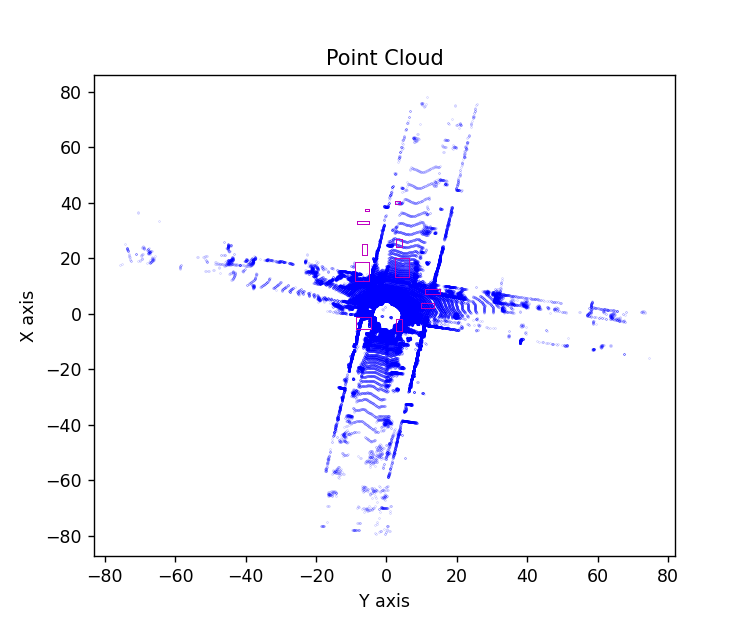

In [265]:
f = plt.figure(figsize=(6, 5))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [271]:
# %time cloud = common.(scan, label, obstacle_lst)

<IPython.core.display.Javascript object>


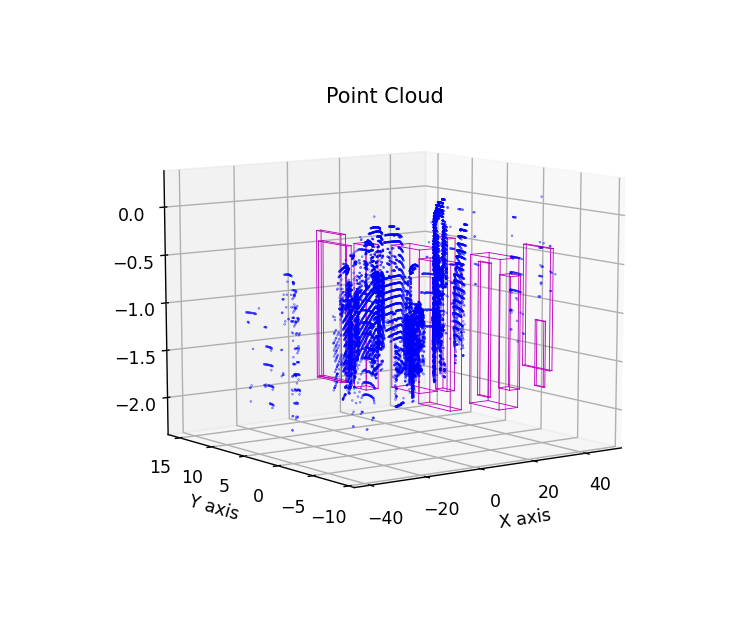

In [267]:
spoints = cloud.points[['x','y','z']]
%matplotlib notebook
f = plt.figure(figsize=(6, 5))
axes = [0,1,2]
ax = f.add_subplot(111, projection='3d') 
# ax = f.add_subplot(111) 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

## Getting bounding boxes for sequence 00

In [394]:
import glob
scan_lst = sorted(glob.glob("../dataset/sequences/00/velodyne/*.bin"))
labels_lst = sorted(glob.glob("../dataset/sequences/00/labels/*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [398]:
from scripts import test
test = imp.reload(test)

In [399]:
%%time
# write_path = '../dataset/sequences/00/velodyne/000355.bin'
bbox_dct, exec_time_dct = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                                 pipeline_optimized, write_path=None,
                                                                         x_voxels=25,
                                                                         y_voxels=20,
                                                                         z_voxels=5)


CPU times: user 4min 4s, sys: 4.47 s, total: 4min 9s
Wall time: 4min 42s


In [404]:
time_stat = list(exec_time_dct.values())
print('Min process time {}'.format(min(time_stat)))
print('Mean process time {}'.format(np.mean(time_stat)))
print('Max process time {}'.format(max(time_stat)))

Min process time 0:00:00.303322
Mean process time 0:00:00.526401
Max process time 0:00:01.356466


In [432]:
time_stat[78].microseconds

867140

In [439]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = [tdelta.microseconds for tdelta in time_stat]

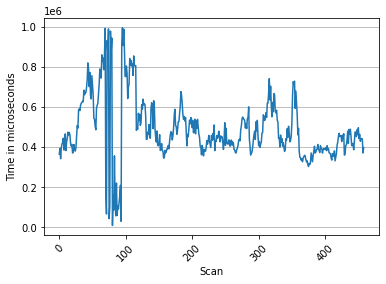

In [441]:
import matplotlib.pyplot as plt
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time in microseconds')
# plt.grid()
ax = plt.axes()        
ax.yaxis.grid()
plt.xticks(rotation=45)
plt.show()